In [31]:
# ========== ----- ========== Import Libraries ========== ----- ========== #
!pip install pyspark

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from joblib import dump, load
import matplotlib.pyplot as plt
from pyspark.sql.functions import count
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Import required libraries
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark import SparkContext

# Import necessary libraries
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.sql import SparkSession

# ========== ----- ========== End ========== ----- ========== #

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
##The dataset is loaded to your GDrive so need to be mounted
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# ========== ----- ========== Import Dataset ========== ----- ========== #

# Create a SparkContext object
spark=SparkSession.builder\
    .master("local[5]")\
    .appName("Data Analysis")\
    .getOrCreate()

# Load data into Spark DataFrame
df = spark.read.csv("/content/drive/MyDrive/final_df.csv", header=True)

header = df.first()
print(header)

# ========== ----- ========== End ========== ----- ========== #


Row(client_catg='11', avg_elec_reading_remarque='6.971428571', avg_elec_consommation_level_1='352.4', avg_elec_consommation_level_2='10.57142857', avg_elec_consommation_level_3='0', avg_elec_consommation_level_4='0', avg_elec_months_number='4.628571429', avg_gaz_reading_remarque='0', avg_gaz_consommation_level_1='0', avg_gaz_consommation_level_2='0', avg_gaz_consommation_level_3='0', avg_gaz_consommation_level_4='0', avg_gaz_months_number='0', min_elec_reading_remarque='6', min_elec_consommation_level_1='38', min_elec_consommation_level_2='0', min_elec_consommation_level_3='0', min_elec_consommation_level_4='0', min_elec_months_number='2', min_gaz_reading_remarque='0', min_gaz_consommation_level_1='0', min_gaz_consommation_level_2='0', min_gaz_consommation_level_3='0', min_gaz_consommation_level_4='0', min_gaz_months_number='0', max_elec_reading_remarque='9', max_elec_consommation_level_1='1200', max_elec_consommation_level_2='186', max_elec_consommation_level_3='0', max_elec_consommat

In [29]:
# ========== ----- ========== Prepare The Data ========== ----- ========== #

# Filter out the rows where the consumption value is greater than 10000
df = df.filter(col("avg_elec_months_number") <= 10000)
df = df.filter(col("avg_gaz_months_number") <= 10000)
  
# ========== ----- ========== End ========== ----- ========== #

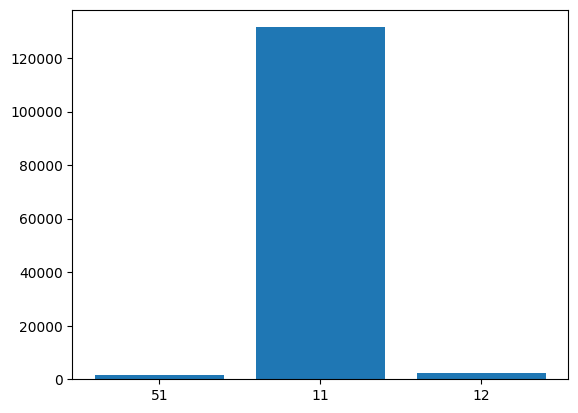

We have 3 categories (11, 12, 51), most of clients are related to category 11.


In [33]:
# ========== ----- ========== User Category ========== ----- ========== #

# Group the data by the Category column and count the number of occurrences of each value
category_counts = df.groupBy("client_catg").agg(count("*").alias("count"))

# Convert the result to a Pandas DataFrame (which is easier to plot with Matplotlib)
pandas_df = category_counts.toPandas()

# Plot the bar chart
plt.bar(pandas_df["client_catg"], pandas_df["count"])
plt.show()
print("We have 3 categories (11, 12, 51), most of clients are related to category 11.")

# ========== ----- ========== End ========== ----- ========== #

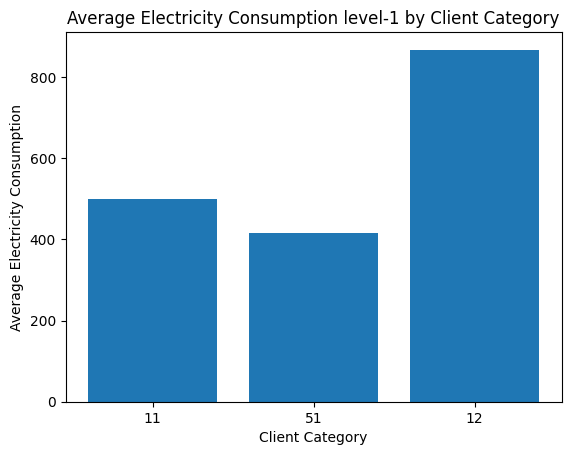

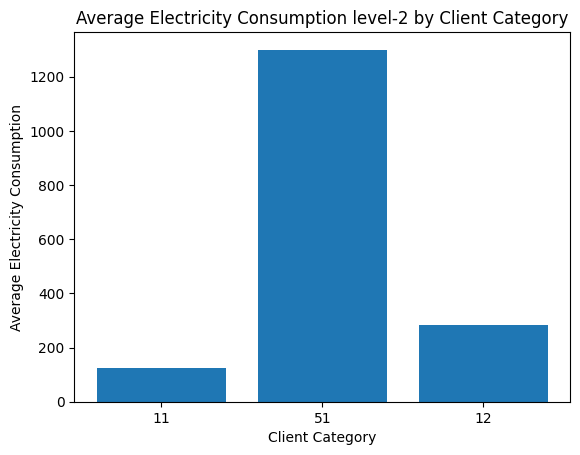

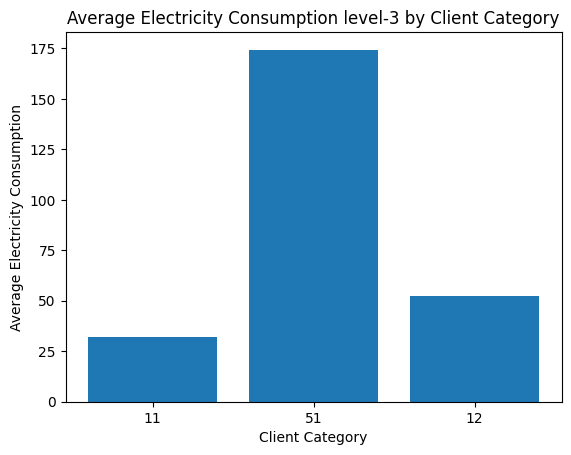

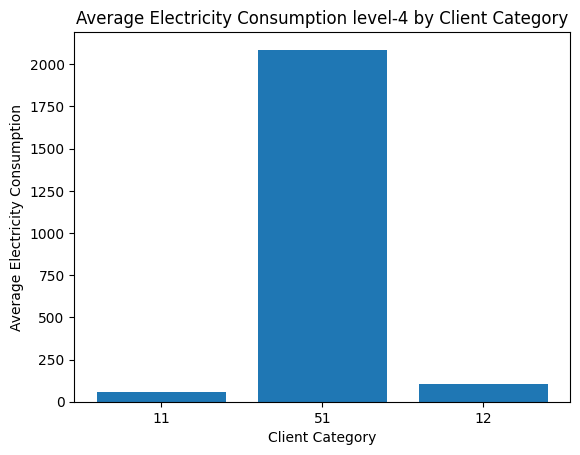

In [26]:
# ========== ----- ========== Electricity Consumption ========== ----- ========== #

titles = ["Average Electricity Consumption level-1 by Client Category",
          "Average Electricity Consumption level-2 by Client Category",
          "Average Electricity Consumption level-3 by Client Category",
          "Average Electricity Consumption level-4 by Client Category",
          ]
groups = ["avg_elec_consommation_level_1",
          "avg_elec_consommation_level_2",
          "avg_elec_consommation_level_3",
          "avg_elec_consommation_level_4",
          ]

index = 0
for group, title in zip(groups, titles):

  mappedData = df.rdd.map(lambda x: (x[0], (float(x[index+2]), 1)))
  reducedData = mappedData.reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))
  averages = reducedData.mapValues(lambda x: round(x[0]/x[1], 2)).collect()
  
  categories = [row[0] for row in averages]
  averages = [row[1] for row in averages]

  plt.bar(categories, averages)
  plt.title(title)
  plt.xlabel("Client Category")
  plt.ylabel("Average Electricity Consumption")
  plt.show()

  index+=1

print("Category 3 consumes electricity more than category 1 & 2.")
# ========== ----- ========== End ========== ----- ========== #


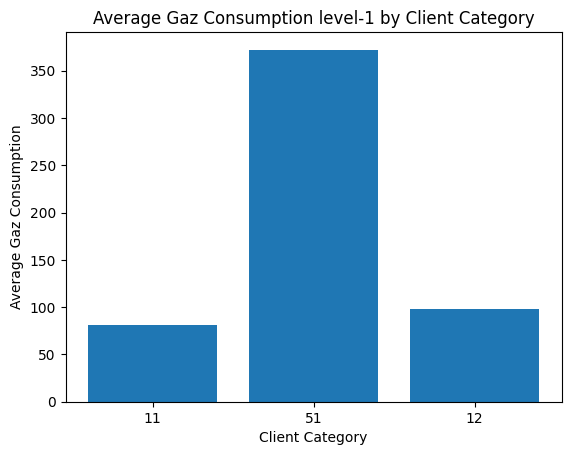

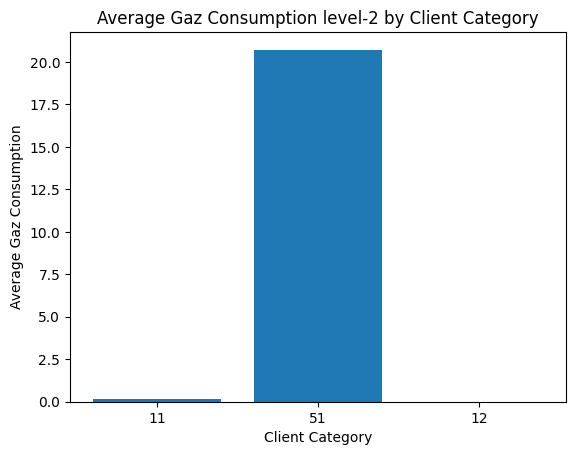

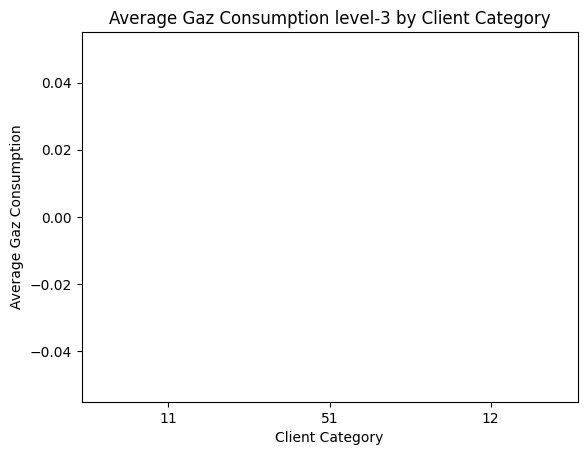

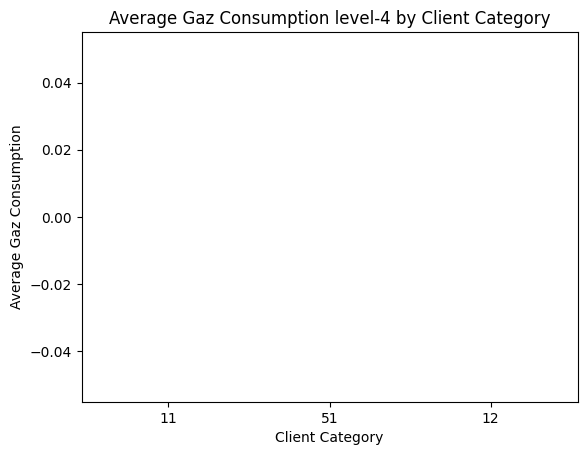

In [27]:
# ========== ----- ========== Gaz Consumption ========== ----- ========== #

titles = ["Average Gaz Consumption level-1 by Client Category",
          "Average Gaz Consumption level-2 by Client Category",
          "Average Gaz Consumption level-3 by Client Category",
          "Average Gaz Consumption level-4 by Client Category",
          ]
groups = ["avg_gaz_consommation_level_1",
          "avg_gaz_consommation_level_2",
          "avg_gaz_consommation_level_3",
          "avg_gaz_consommation_level_4",
          ]

index = 0
for group, title in zip(groups, titles):

  mappedData = df.rdd.map(lambda x: (x[0], (float(x[index+8]), 1)))
  reducedData = mappedData.reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))
  averages = reducedData.mapValues(lambda x: round(x[0]/x[1], 2)).collect()
  
  categories = [row[0] for row in averages]
  averages = [row[1] for row in averages]

  plt.bar(categories, averages)
  plt.title(title)
  plt.xlabel("Client Category")
  plt.ylabel("Average Gaz Consumption")
  plt.show()

  index+=1

print("Category 3 consumes Gaz more than category 1 & 2.")
print("In general, no categpry consume more than level 2 in Gaz.")
# ========== ----- ========== End ========== ----- ========== #

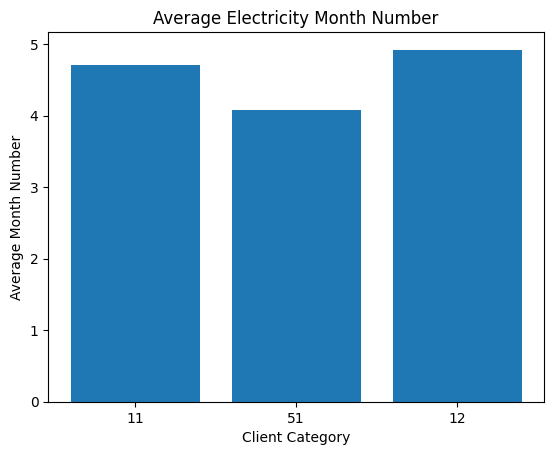

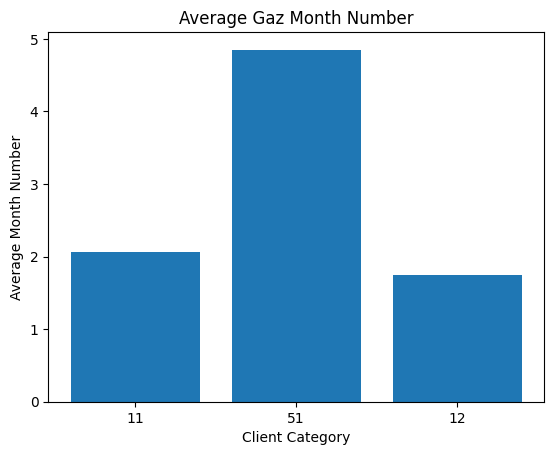

In [30]:
# ========== ----- ========== aze & Electricity Month Number ========== ----- ========== #

titles = ["Average Electricity Month Number",
          "Average Gaz Month Number",
          ]
groups = [6,
          12,
          ]

index = 0
for group, title in zip(groups, titles):

  mappedData = df.rdd.map(lambda x: (x[0], (float(x[groups[index]]), 1)))
  reducedData = mappedData.reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))
  averages = reducedData.mapValues(lambda x: round(x[0]/x[1], 2)).collect()
  
  categories = [row[0] for row in averages]
  averages = [row[1] for row in averages]

  plt.bar(categories, averages)
  plt.title(title)
  plt.xlabel("Client Category")
  plt.ylabel("Average Month Number")
  plt.show()

  index+=1

# ========== ----- ========== End ========== ----- ========== #

In [14]:
# ========== ----- ========== Spark Session ========== ----- ========== #

# Stop the Spark session
spark.stop()

# ========== ----- ========== End ========== ----- ========== #